In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so
import time
import multiprocessing as mp
from tqdm import tqdm_notebook as tqdm
import readdy

## Task 1
Simulate given FJC and FRC models and determine $l_p$

In [2]:
chain_type = "frc" # fjc or frc

In [3]:
out_dir = "/home/chris/workspace/data/workshop/polymer_solution"
out_file = os.path.join(out_dir, f"polymer_{chain_type}.h5")
checkpoint_dir = os.path.join(out_dir, f"ckpts_{chain_type}")

In [4]:
bond_length = 0.48
chain_length = 50
n_steps = 2000000
dt = 0.005

In [5]:
system = readdy.ReactionDiffusionSystem(
    box_size=[102., 102., 102.],
    periodic_boundary_conditions=[False, False, False],
    unit_system=None)

system.add_topology_species("monomer", 0.1)

system.topologies.add_type("polymer")

origin = np.array([-50., -50., -50.])
extent = np.array([100., 100., 100.])

system.potentials.add_box("monomer", force_constant=50., origin=origin, extent=extent)

system.topologies.configure_harmonic_bond("monomer", "monomer", force_constant=50., length=bond_length)
if chain_type=="frc":
    system.topologies.configure_harmonic_angle(
        "monomer", "monomer", "monomer", force_constant=20.,
        equilibrium_angle=2.530727415391778)

In [10]:
sim = system.simulation("SingleCPU")

sim.output_file = out_file

sim.record_trajectory(stride=1000)
sim.observe.particle_positions(stride=1000)

if os.path.exists(checkpoint_dir):
    # load checkpoint
    sim.load_particles_from_latest_checkpoint(checkpoint_dir)
else:
    # new positions
    init_pos = [np.zeros(3)]
    for i in range(1, chain_length):
        displacement = np.random.normal(size=(3))
        displacement /= np.sqrt(np.sum(displacement * displacement))
        displacement *= bond_length
        init_pos.append(init_pos[i - 1] + displacement)
    init_pos = np.array(init_pos)

    # subtract center of mass
    init_pos -= np.mean(init_pos, axis=0)

    top = sim.add_topology("polymer", len(init_pos) * ["monomer"], init_pos)
    for i in range(1, chain_length):
        top.get_graph().add_edge(i - 1, i)

# this also creates the directory
sim.make_checkpoints(n_steps // 100, output_directory=checkpoint_dir, max_n_saves=10)

if os.path.exists(sim.output_file):
    os.remove(sim.output_file)

sim.run(n_steps, dt)

traj = readdy.Trajectory(out_file)
traj.convert_to_xyz(particle_radii={"monomer": bond_length / 2.}, draw_box=True)

  0%|          | 785/200000 [00:00<00:52, 3820.33it/s]

Configured kernel context with:
--------------------------------
 - kBT = 1
 - periodic b.c. = (false, false, false)
 - box size = (102, 102, 102)
 - particle types:
     * Topology particle type "monomer" with D=0.1
 - potentials of order 1:
     * for type "monomer"
         * Box potential with origin=(-50, -50, -50), extent=(100, 100, 100), and force constant k=50
 - topology potential configuration:
     - bonds (1):
         - Bonds for particle types monomer and monomer:
             * Harmonic bond with force constant 50 and length 0.48
     - angles (1):
             * Harmonic angle with force constant 20 and equilibrium angle 2.53073
 - topology types:
     * topology type "polymer" with 0 structural reactions

Configured simulation loop with:
--------------------------------
 - timeStep = 0.005
 - evaluateObservables = true
 - progressOutputStride = 10
 - context written to file = true
 - Performing actions:
   * Initialize neighbor list? true
   * Update neighbor list? tru

100%|██████████| 200000/200000 [00:49<00:00, 4054.72it/s]


In [21]:
traj = readdy.Trajectory(out_file)

times, positions = traj.read_observable_particle_positions()

# convert to numpy array
T = len(positions)
N = len(positions[0])
pos = np.zeros(shape=(T, N, 3))
for t in range(T):
    for n in range(N):
        pos[t, n, 0] = positions[t][n][0]
        pos[t, n, 1] = positions[t][n][1]
        pos[t, n, 2] = positions[t][n][2]

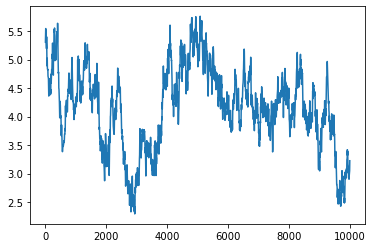

In [22]:
# calculate radius of gyration
mean_pos = np.mean(pos, axis=1)

difference = np.zeros_like(pos)
for i in range(chain_length):
    difference[:, i] = pos[:, i] - mean_pos

assert difference.shape == (T, N, 3)

# square and sum over coordinates (axis=2)
squared_radius_g = np.sum(difference * difference, axis=2)

assert squared_radius_g.shape == (T, N)

# average over particles (axis=1)
squared_radius_g = np.mean(squared_radius_g, axis=1)

radius_g = np.sqrt(squared_radius_g)

assert radius_g.shape == times.shape == (T,)

plt.plot(times * dt, radius_g)

plt.show()

In [ ]:
assert pos.shape == (T, N, 3)

# calculate segments
segments = pos[:, 1:, :] - pos[:, :-1, :]

# normalize segments
#segments = (segments.T / np.sqrt(np.sum(np.power(segments, 2.), axis=2)).T).T

In [ ]:
# calculate segment correlations
n_beads = pos.shape[1]
separations = np.arange(0, n_beads - 1, 1)
corrs = [[] for _ in range(n_beads - 1)]
for i in range(n_beads - 1):
    for j in range(i, n_beads - 1):
        corrs[j - i].append(np.mean(np.sum(segments[:, i, :] * segments[:, j, :], axis=1)))

corrs = np.array([np.mean(c) for c in corrs])

l_p/l 4.634373516835196
l_p 2.224499288080894


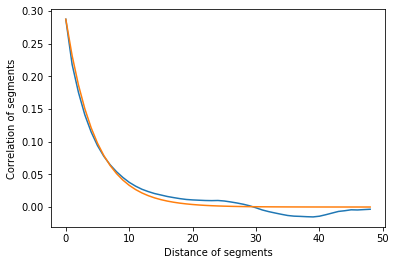

In [23]:
plt.plot(separations, corrs)

def f(s, a):
    return corrs[0] * np.exp(- a * s)

# fit exponential decay to bond vector correlation
popt, pcov = so.curve_fit(f, separations, corrs)
l_p = 1. / popt[0]

plt.plot(separations, f(separations, popt[0]))
plt.xlabel("Distance of segments")
plt.ylabel("Correlation of segments")
print("l_p/l", 1./popt[0])
print("l_p", bond_length/popt[0])

FJC -> Correlation immediately drops to zero, no correlation of segments $l_p\approx 0$

FRC -> Longer correlation $l_p\approx 2$

### Task 2: identify FRC

In [14]:
# get equilibrated samples and calculate segment correlation
a = np.load("a.npy")
b = np.load("b.npy")

In [24]:
assert a.shape == (100, 3)
assert b.shape == (100, 3)

l_p/l 0.400282635032846
l_p 0.19213566481576608


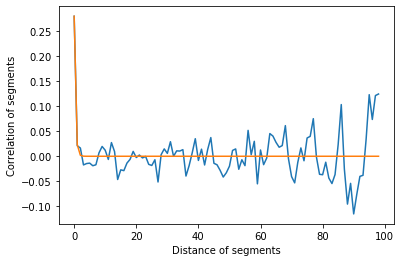

In [19]:
pos = a

# calculate segments
segments = pos[1:, :] - pos[:-1, :]

# normalize segments
#segments = (segments.T / np.sqrt(np.sum(np.power(segments, 2.), axis=1)).T).T

# calculate segment correlations
n_beads = pos.shape[0]
separations = np.arange(0, n_beads - 1, 1)
corrs = [[] for _ in range(n_beads - 1)]
for i in range(n_beads - 1):
    for j in range(i, n_beads - 1):
        corrs[j - i].append(np.sum(segments[i, :] * segments[j, :]))

corrs = np.array([np.mean(c) for c in corrs])
plt.plot(separations, corrs)

def f(s, a):
    return corrs[0] * np.exp(- a * s)

# fit exponential decay to bond vector correlation
popt, pcov = so.curve_fit(f, separations, corrs)
l_p = 1. / popt[0]

plt.plot(separations, f(separations, popt[0]))
plt.xlabel("Distance of segments")
plt.ylabel("Correlation of segments")
print("l_p/l", 1./popt[0])
print("l_p", bond_length/popt[0])

`b` has $l_p\approx 2$, it is the FRC model, that best models a RNA

### Task 3: determine first-passage-time of finding target

In [210]:
n_steps = 30000
dt = 0.001

In [315]:
def target_find(interaction=False, do_traj = True):
    out_file = os.path.join(out_dir, f"find_target_{'int' if interaction else 'noint'}.h5")
    
    system = readdy.ReactionDiffusionSystem(
        box_size=[16., 16., 16.],
        periodic_boundary_conditions=[False, False, False],
        unit_system=None)

    system.add_topology_species("monomer", 0.1)
    system.add_topology_species("target", 0.1)
    system.add_species("A", 0.5)
    system.add_species("B", 0.5)

    system.topologies.add_type("polymer")

    origin = np.array([-7.5, -7.5, -7.5])
    extent = np.array([15., 15., 15.])

    system.potentials.add_box("monomer", force_constant=50., origin=origin, extent=extent)
    system.potentials.add_box("target", force_constant=50., origin=origin, extent=extent)
    system.potentials.add_box("A", force_constant=50., origin=origin, extent=extent)
    system.potentials.add_box("B", force_constant=50., origin=origin, extent=extent)
                            
    system.potentials.add_harmonic_repulsion(
        "monomer", "monomer", force_constant=50., interaction_distance=1.1*bond_length)
    system.potentials.add_harmonic_repulsion(
        "A", "A", force_constant=50., interaction_distance=1.5*bond_length)
    
    if interaction:
        system.potentials.add_weak_interaction_piecewise_harmonic(
            "A", "monomer", force_constant=50., desired_distance=bond_length, depth=1.4, cutoff=2.2*bond_length)
    
    system.topologies.configure_harmonic_bond("monomer", "monomer", force_constant=50., length=bond_length)
    system.topologies.configure_harmonic_bond("monomer", "target", force_constant=50., length=bond_length)
    
    
    system.topologies.configure_harmonic_angle(
        "monomer", "monomer", "monomer", force_constant=20.,
        equilibrium_angle=2.530727415391778)
    system.topologies.configure_harmonic_angle(
        "monomer", "monomer", "target", force_constant=20.,
        equilibrium_angle=2.530727415391778)
    system.topologies.configure_harmonic_angle(
        "monomer", "target", "monomer", force_constant=20.,
        equilibrium_angle=2.530727415391778)
    
    # immediate conversion once the target is found
    system.reactions.add(f"found: A +({bond_length}) target -> B + target", rate=10000.)
    
    sim = system.simulation("SingleCPU")

    sim.output_file = out_file

    if do_traj:
        sim.record_trajectory(n_steps//300)
    sim.observe.number_of_particles(stride=1, types=["B"])

    init_pos = np.load("b.npy")

    types = len(init_pos) * ["monomer"]
    types[10] = "target" # define the target to be the 10-th monomer
                            
    #print("init_pos.shape", init_pos.shape)
    #print("target position", init_pos[len(types)//2])

    top = sim.add_topology("polymer", types, init_pos)
    for i in range(1, len(init_pos)):
        top.get_graph().add_edge(i - 1, i)
    
    # position the protein
    sim.add_particles("A", 0.5*np.random.normal(size=(50,3)))

    if os.path.exists(sim.output_file):
        os.remove(sim.output_file)
    
    #sim.skin = 0.1
    sim.show_progress = False
                            
    #print("Simulate until time", n_steps * dt)

    sim.run(n_steps, dt, show_summary=False)

    traj = readdy.Trajectory(out_file)
    if do_traj:
        traj.convert_to_xyz(
            particle_radii={"monomer": bond_length / 2.,
                            "target": bond_length / 2.,
                            "A": bond_length / 2.,
                            "B": bond_length / 2.},
            draw_box=True)
    _, counts = traj.read_observable_number_of_particles()
    counts = np.squeeze(counts)
                            
    largerzero = counts > 0
    if np.alltrue(np.logical_not(largerzero)):
        passage_time = None
    else:
        idx = np.argmax(largerzero)
        passage_time = idx * dt
    
    return passage_time

In [316]:
ts_int = []
ts_noint = []

In [317]:
#def worker(i):
#    return target_find(i, interaction=True)

In [318]:
#n = 20
#sleeptimes = np.random.uniform(size=(n,)).tolist()
#with mp.Pool(4) as p:
#      ts_int += list(tqdm(p.imap(worker, sleeptimes), total=n))

In [323]:
n=50
for _ in tqdm(range(n)):
    ts_int.append(target_find(interaction=True, do_traj=True))

In [324]:
n=50
for _ in tqdm(range(n)):
    ts_noint.append(target_find(interaction=False, do_traj=False))

In [333]:
len(ts_int)

100

In [334]:
len(ts_noint)

100

Probability of no event ocurring before $t$ is $P(X>t)=P\{N(t)=0\}=e^{-\lambda t}$. Hence the probability of any event ocurring before $t$ is $P(X\leq t)=1 - P(X>t)=1-e^{\lambda t}$. The probability __density__ of waiting times is then $p(t)=\frac{\mathrm{d}P}{\mathrm{d}t}=\lambda e^{-\lambda t}$, which is normalized such that $\int_0^\infty p(t)\mathrm{d}t=1$

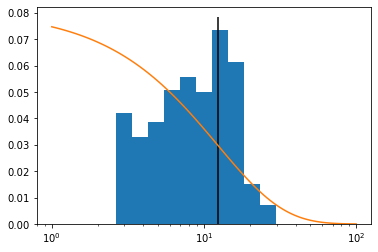

In [331]:
ts = [x for x in ts_noint if x is not None]
plt.hist(ts, bins=np.logspace(0,2,20), density=True)
plt.xscale("log")
xs = np.logspace(0, 2, 100)
# max. lik. waiting time fit leads to parameter being the average rate
k = float(len(ts))/np.sum(ts)
plt.plot(xs, k*np.exp(-k*xs))
plt.vlines(np.mean(ts), *plt.ylim())

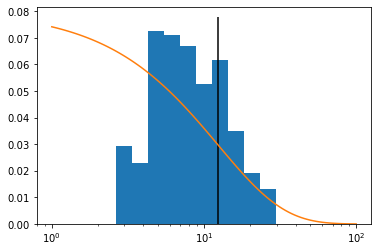

In [332]:
ts = [x for x in ts_int if x is not None]
plt.hist(ts, bins=np.logspace(0,2,20), density=True)
plt.xscale("log")
xs = np.logspace(0, 2, 100)
# max. lik. waiting time fit leads to parameter being the average rate
k = float(len(ts))/np.sum(ts)
plt.plot(xs, k*np.exp(-k*xs))
plt.vlines(np.mean(ts), *plt.ylim())

Outcome:
- Both are not modeled well by a memory-less process
- The interacting case is more tilted towards lower times
- However this effect is not well captured by the mean first passage time

## Extra task: Calculate radius of gyration for varying chain length

In [ ]:
#extra

# calculate radius of gyration
mean_pos = np.mean(pos, axis=1)

difference = np.zeros_like(pos)
for i in range(chain_length):
    difference[:, i] = pos[:, i] - mean_pos

assert difference.shape == (T, N, 3)

# square and sum over coordinates (axis=2)
squared_radius_g = np.sum(difference * difference, axis=2)

assert squared_radius_g.shape == (T, N)

# average over particles (axis=1)
squared_radius_g = np.mean(squared_radius_g, axis=1)

radius_g = np.sqrt(squared_radius_g)

assert radius_g.shape == times.shape == (T,)

plt.plot(times * dt, radius_g)

plt.show()